In [1]:
from astropy.coordinates import Angle
import pandas as pd
import numpy as np
import astropy.units as u

from km3irf import irf_tools, utils

In [2]:
# parts of build IRF
def apply_cuts(dataset):
    """Apply cuts to the created data frame."""
    mask = get_cut_mask(dataset.bdt0, dataset.bdt1, dataset.dir_z)
    # dataset = dataset[mask]
    dataset = dataset[mask].copy()
    return dataset


def get_cut_mask(bdt0, bdt1, dir_z):
    """Create a cut mask for chosen cuts"""

    dir_z_deg = np.arccos(dir_z) * 180 / np.pi

    mask_down = bdt0 >= 11  # remove downgoing events
    clear_signal = bdt0 == 12  # very clear signal
    loose_up = np.bitwise_and(
        dir_z_deg < 80, bdt1 > 0.0
    )  # apply loose cut on upgoing events
    strong_horizontal = np.bitwise_and(
        dir_z_deg > 80, bdt1 > 0.7
    )  # apply strong cut on horizontal events

    return np.bitwise_and(
        mask_down,
        np.bitwise_or(clear_signal, np.bitwise_or(loose_up, strong_horizontal)),
    )

In [3]:
df = pd.read_csv("../../temp_dataset.csv")
df_cut = apply_cuts(dataset=df)

In [4]:
len(df), len(df_cut)

(200, 87)

In [5]:
df.head()

,E,dir_x,dir_y,dir_z,E_mc,dir_x_mc,dir_y_mc,dir_z_mc,weight_w2,bdt0,bdt1
0,349.621209,-0.670299,0.270036,0.691216,268.990,-0.670996,0.286741,0.683772,4.510000e+11,12.0,-2.000000
1,20.423436,0.327411,0.078130,-0.941646,178.710,0.327387,0.079789,-0.941515,1.182000e+11,1.0,-2.000000
2,184.966630,0.794867,0.354793,-0.492248,214.610,0.799260,0.353143,-0.486285,1.960000e+11,1.0,-2.000000
3,52.327015,0.455668,-0.632999,0.625843,291.347,0.432161,-0.625802,0.649314,5.622000e+11,11.0,0.998906
4,248.662668,0.553978,-0.036197,0.831744,299.805,0.835802,-0.326768,0.441200,5.829000e+11,10.0,-2.000000


Now it needs to fill all bins for PSF

In [14]:
# create bins
cos_theta_binE = np.linspace(1, -1, 7)
energy_binE = np.logspace(2, 8, 25)
rad_binE = np.concatenate(
    (
        np.linspace(0, 1, 20, endpoint=False),
        np.linspace(1, 5, 40, endpoint=False),
        np.linspace(5, 30, 51),
        [180.0],
    )
)

theta_binE = np.arccos(cos_theta_binE)
# Bin centers
energy_binC = np.sqrt(energy_binE[:-1] * energy_binE[1:])
theta_binC = np.arccos(0.5 * (cos_theta_binE[:-1] + cos_theta_binE[1:]))
rad_binC = 0.5 * (rad_binE[1:] + rad_binE[:-1])

weights_array = np.ones(len(df), dtype=np.float64)

In [20]:
th_rad = theta_binE * u.rad
th_rad.to("deg").value

array([  0.        ,  48.1896851 ,  70.52877937,  90.        ,
       109.47122063, 131.8103149 , 180.        ])

In [7]:
len(rad_binC)

111

In [7]:
psf = irf_tools.psf_3D(
    e_bins=energy_binE,
    t_bins=theta_binE,
    r_bins=rad_binE,
    dataset=df_cut,
    weights=weights_array,
)
psf.sum()

87.0

In [2]:
psf_class = utils.DrawPSF()
psf_class.energy_center

array([2.142746, 2.392746, 2.642746, 2.892746, 3.142746, 3.392746,
       3.642746, 3.892746, 4.142746, 4.392746, 4.642746, 4.892746,
       5.142746, 5.392746, 5.642746, 5.892746, 6.142746, 6.392746,
       6.642746, 6.892746, 7.142746, 7.392746, 7.642746, 7.892746],
      dtype=float32)

In [3]:
psf_class.energy_logcenter

array([1.3335214e+02, 2.3713736e+02, 4.2169647e+02, 7.4989423e+02,
       1.3335214e+03, 2.3713735e+03, 4.2169648e+03, 7.4989419e+03,
       1.3335215e+04, 2.3713738e+04, 4.2169652e+04, 7.4989422e+04,
       1.3335214e+05, 2.3713738e+05, 4.2169650e+05, 7.4989419e+05,
       1.3335214e+06, 2.3713738e+06, 4.2169655e+06, 7.4989425e+06,
       1.3335214e+07, 2.3713736e+07, 4.2169652e+07, 7.4989416e+07],
      dtype=float32)

In [9]:
psf_class.rad_center

array([2.5000000e-02, 7.5000003e-02, 1.2500000e-01, 1.7500001e-01,
       2.2499999e-01, 2.7500001e-01, 3.2499999e-01, 3.7500000e-01,
       4.2500001e-01, 4.7499999e-01, 5.2499998e-01, 5.7500005e-01,
       6.2500000e-01, 6.7499995e-01, 7.2500002e-01, 7.7499998e-01,
       8.2500005e-01, 8.7500000e-01, 9.2499995e-01, 9.7500002e-01,
       1.0500000e+00, 1.1500001e+00, 1.2500000e+00, 1.3499999e+00,
       1.4500000e+00, 1.5500000e+00, 1.6500001e+00, 1.7500000e+00,
       1.8499999e+00, 1.9500000e+00, 2.0500000e+00, 2.1500001e+00,
       2.2500000e+00, 2.3499999e+00, 2.4500000e+00, 2.5500000e+00,
       2.6500001e+00, 2.7500000e+00, 2.8499999e+00, 2.9500000e+00,
       3.0500000e+00, 3.1500001e+00, 3.2500000e+00, 3.3499999e+00,
       3.4500000e+00, 3.5500000e+00, 3.6500001e+00, 3.7500000e+00,
       3.8499999e+00, 3.9500000e+00, 4.0500002e+00, 4.1499996e+00,
       4.2500000e+00, 4.3500004e+00, 4.4499998e+00, 4.5500002e+00,
       4.6499996e+00, 4.7500000e+00, 4.8500004e+00, 4.9499998e

In [7]:
a.to("deg")

<Quantity [1.43239450e+00, 4.29718351e+00, 7.16197252e+00, 1.00267620e+01,
           1.28915501e+01, 1.57563400e+01, 1.86211281e+01, 2.14859180e+01,
           2.43507080e+01, 2.72154961e+01, 3.00802841e+01, 3.29450760e+01,
           3.58098640e+01, 3.86746483e+01, 4.15394402e+01, 4.44042282e+01,
           4.72690201e+01, 5.01338081e+01, 5.29985924e+01, 5.58633881e+01,
           6.01605682e+01, 6.58901520e+01, 7.16197281e+01, 7.73492966e+01,
           8.30788803e+01, 8.88084564e+01, 9.45380402e+01, 1.00267616e+02,
           1.05997185e+02, 1.11726776e+02, 1.17456345e+02, 1.23185936e+02,
           1.28915512e+02, 1.34645081e+02, 1.40374664e+02, 1.46104233e+02,
           1.51833817e+02, 1.57563400e+02, 1.63292969e+02, 1.69022552e+02,
           1.74752121e+02, 1.80481720e+02, 1.86211288e+02, 1.91940857e+02,
           1.97670441e+02, 2.03400024e+02, 2.09129608e+02, 2.14859177e+02,
           2.20588745e+02, 2.26318329e+02, 2.32047928e+02, 2.37777466e+02,
           2.43507065e+02

In [13]:
np.sqrt(psf_class.data["ENERG_LO"][0] * psf_class.data["ENERG_HI"][0])

array([1.3335214e+02, 2.3713736e+02, 4.2169647e+02, 7.4989423e+02,
       1.3335214e+03, 2.3713735e+03, 4.2169648e+03, 7.4989419e+03,
       1.3335215e+04, 2.3713738e+04, 4.2169652e+04, 7.4989422e+04,
       1.3335214e+05, 2.3713738e+05, 4.2169650e+05, 7.4989419e+05,
       1.3335214e+06, 2.3713738e+06, 4.2169655e+06, 7.4989425e+06,
       1.3335214e+07, 2.3713736e+07, 4.2169652e+07, 7.4989416e+07],
      dtype=float32)

In [27]:
psf.shape

(111, 6, 24)

In [11]:
psf_class.evaluate((energy=2.5e2, zenith=1.2, rad=21))

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (316252371.py, line 1)

In [9]:
import astropy.units as u

In [40]:
rad_deg = rad_binE * u.deg
rad_deg.value

array([0.00e+00, 5.00e-02, 1.00e-01, 1.50e-01, 2.00e-01, 2.50e-01,
       3.00e-01, 3.50e-01, 4.00e-01, 4.50e-01, 5.00e-01, 5.50e-01,
       6.00e-01, 6.50e-01, 7.00e-01, 7.50e-01, 8.00e-01, 8.50e-01,
       9.00e-01, 9.50e-01, 1.00e+00, 1.10e+00, 1.20e+00, 1.30e+00,
       1.40e+00, 1.50e+00, 1.60e+00, 1.70e+00, 1.80e+00, 1.90e+00,
       2.00e+00, 2.10e+00, 2.20e+00, 2.30e+00, 2.40e+00, 2.50e+00,
       2.60e+00, 2.70e+00, 2.80e+00, 2.90e+00, 3.00e+00, 3.10e+00,
       3.20e+00, 3.30e+00, 3.40e+00, 3.50e+00, 3.60e+00, 3.70e+00,
       3.80e+00, 3.90e+00, 4.00e+00, 4.10e+00, 4.20e+00, 4.30e+00,
       4.40e+00, 4.50e+00, 4.60e+00, 4.70e+00, 4.80e+00, 4.90e+00,
       5.00e+00, 5.50e+00, 6.00e+00, 6.50e+00, 7.00e+00, 7.50e+00,
       8.00e+00, 8.50e+00, 9.00e+00, 9.50e+00, 1.00e+01, 1.05e+01,
       1.10e+01, 1.15e+01, 1.20e+01, 1.25e+01, 1.30e+01, 1.35e+01,
       1.40e+01, 1.45e+01, 1.50e+01, 1.55e+01, 1.60e+01, 1.65e+01,
       1.70e+01, 1.75e+01, 1.80e+01, 1.85e+01, 1.90e+01, 1.95e

In [2]:
psf_plotter = utils.DrawPSF()

# Example usage of the evaluate function
energy_values = [1000, 4000]  # Energy values in TeV
zenith_offsets = [0.7, 0.78]  # Zenith offsets in radians
radial_offsets = [12, 15]  # Radial offsets in degrees

# Create a list to store the PSF values
psf_values = []

# Iterate over the provided values and evaluate the PSF for each combination
for energy, zenith, rad in zip(energy_values, zenith_offsets, radial_offsets):
    psf_value = psf_plotter.evaluate_3d(energy=energy, zenith=zenith, rad=rad)
    psf_values.append(psf_value)

print("PSF values:", psf_values)

PSF values: [array([[[0.0482086]]]), array([[[0.23546699]]])]


In [5]:
outcome_psf = psf_plotter.to_psf1D(energy=2000, zenith=0.2)
outcome_psf.shape

(111,)

In [22]:
psf_values[0][0][0]

array([0.0482086])

In [3]:
psf_plotter.interpolate_containment()

TypeError: object of type 'numpy.float32' has no len()

In [11]:
rad = rad_deg.to("rad")
len(rad)

112

In [46]:
rad_C_deg = rad_binC * u.deg
rad_C = rad_C_deg.to("rad")
len(rad_C)

111

In [47]:
rad_C_deg

<Quantity [2.500e-02, 7.500e-02, 1.250e-01, 1.750e-01, 2.250e-01,
           2.750e-01, 3.250e-01, 3.750e-01, 4.250e-01, 4.750e-01,
           5.250e-01, 5.750e-01, 6.250e-01, 6.750e-01, 7.250e-01,
           7.750e-01, 8.250e-01, 8.750e-01, 9.250e-01, 9.750e-01,
           1.050e+00, 1.150e+00, 1.250e+00, 1.350e+00, 1.450e+00,
           1.550e+00, 1.650e+00, 1.750e+00, 1.850e+00, 1.950e+00,
           2.050e+00, 2.150e+00, 2.250e+00, 2.350e+00, 2.450e+00,
           2.550e+00, 2.650e+00, 2.750e+00, 2.850e+00, 2.950e+00,
           3.050e+00, 3.150e+00, 3.250e+00, 3.350e+00, 3.450e+00,
           3.550e+00, 3.650e+00, 3.750e+00, 3.850e+00, 3.950e+00,
           4.050e+00, 4.150e+00, 4.250e+00, 4.350e+00, 4.450e+00,
           4.550e+00, 4.650e+00, 4.750e+00, 4.850e+00, 4.950e+00,
           5.250e+00, 5.750e+00, 6.250e+00, 6.750e+00, 7.250e+00,
           7.750e+00, 8.250e+00, 8.750e+00, 9.250e+00, 9.750e+00,
           1.025e+01, 1.075e+01, 1.125e+01, 1.175e+01, 1.225e+01,
          

In [13]:
# increase number of rad bins in 10 times
rad_max = Angle(np.linspace(0, rad[-1].value, 10 * len(rad)), unit="rad")
rad[-1].value

3.141592653589793

In [35]:
np.linspace(1, 10, 101)

array([ 1.  ,  1.09,  1.18,  1.27,  1.36,  1.45,  1.54,  1.63,  1.72,
        1.81,  1.9 ,  1.99,  2.08,  2.17,  2.26,  2.35,  2.44,  2.53,
        2.62,  2.71,  2.8 ,  2.89,  2.98,  3.07,  3.16,  3.25,  3.34,
        3.43,  3.52,  3.61,  3.7 ,  3.79,  3.88,  3.97,  4.06,  4.15,
        4.24,  4.33,  4.42,  4.51,  4.6 ,  4.69,  4.78,  4.87,  4.96,
        5.05,  5.14,  5.23,  5.32,  5.41,  5.5 ,  5.59,  5.68,  5.77,
        5.86,  5.95,  6.04,  6.13,  6.22,  6.31,  6.4 ,  6.49,  6.58,
        6.67,  6.76,  6.85,  6.94,  7.03,  7.12,  7.21,  7.3 ,  7.39,
        7.48,  7.57,  7.66,  7.75,  7.84,  7.93,  8.02,  8.11,  8.2 ,
        8.29,  8.38,  8.47,  8.56,  8.65,  8.74,  8.83,  8.92,  9.01,
        9.1 ,  9.19,  9.28,  9.37,  9.46,  9.55,  9.64,  9.73,  9.82,
        9.91, 10.  ])

In [41]:
arr = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Sum along axis 0 (columns)
sum_axis_0 = np.sum(arr, axis=0)

# Sum along axis 1 (rows)
sum_axis_1 = np.sum(arr, axis=1)

print("Sum along axis 0:", sum_axis_0)
print("Sum along axis 1:", sum_axis_1)

Sum along axis 0: [12 15 18]
Sum along axis 1: [ 6 15 24]


In [49]:
psf_value = np.sum(psf, axis=(1, 2))
psf_value.sum()

87.0

In [ ]:
p

In [19]:
rad1 = np.atleast_1d(rad_max)

In [20]:
rad1 == rad_max

array([ True,  True,  True, ...,  True,  True,  True])

In [21]:
len(rad1)

1120

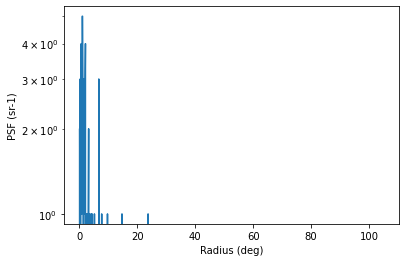

In [33]:
import matplotlib.pyplot as plt

ax = plt.gca()

ax.plot(rad_C_deg, psf_value)
ax.set_yscale("log")
ax.set_xlabel("Radius (deg)")
ax.set_ylabel("PSF (sr-1)")
plt.show()

In [51]:
# ax.hist(rad_C_deg.value, bins=rad_deg.value, weights=psf_value)
ax.hist(rad_C_deg.value, bins=rad_deg.value)

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([0.00e+00, 5.00e-02, 1.00e-01, 1.50e-01, 2.00e-01, 2.50e-01,
        3.00e-01, 3.50e-01, 4.00e-01, 4.50e-01, 5.00e-01, 5.50e-01,
        6.00e-01, 6.50e-01, 7.00e-01, 7.50e-01, 8.00e-01, 8.50e-01,
        9.00e-01, 9.50e-01, 1.00e+00, 1.10e+00, 1.20e+00, 1.30e+00,
        1.40e+00, 1.50e+00, 1.60e+00, 1.70e+00, 1.80e+00, 1.90e+00,
        2.00e+00, 2.10e+00, 2.20e+00, 2.30e+00, 2.40e+00, 2.50e+00,
        2.60e+00, 2.70e+00, 2.80e+00, 2.90e+00, 3.00e+00, 3.10e+00,
        3.20e+00, 3.30

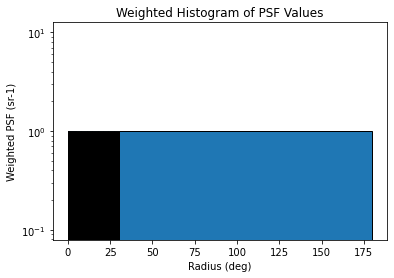

In [53]:
fig, ax = plt.subplots()

# Plot the histogram
ax.hist(rad_C_deg.value, bins=rad_deg.value, weights=psf_value, edgecolor="black")
# ax.hist(rad_C_deg.value, bins=rad_deg.value, edgecolor='black')

ax.set_yscale("log")
ax.set_xlabel("Radius (deg)")
ax.set_ylabel("Weighted PSF (sr-1)")
ax.set_title("Weighted Histogram of PSF Values")

plt.show()

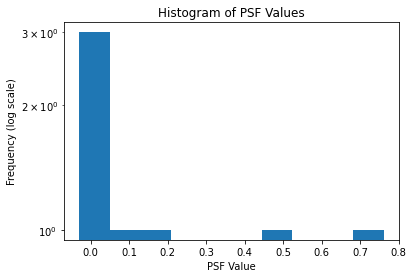

In [34]:
rad_C_deg = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
psf_value = [0.01, 0.1, 0.5, 0.8, 0.2, 0.05, 0.01]

# Create a histogram with specified bins
n_bins = 10  # You can adjust this based on your data and preferences
hist, bin_edges = np.histogram(psf_value, bins=n_bins)

# Create the histogram plot
plt.bar(bin_edges[:-1], hist, width=bin_edges[1] - bin_edges[0])

plt.yscale("log")
plt.xlabel("PSF Value")
plt.ylabel("Frequency (log scale)")
plt.title("Histogram of PSF Values")
plt.show()

In [36]:
bin_edges

array([0.01 , 0.089, 0.168, 0.247, 0.326, 0.405, 0.484, 0.563, 0.642,
       0.721, 0.8  ])

In [22]:
import scipy
from km3irf.interpolation import ScaledRegularGridInterpolator

In [23]:
def interpolate(rad, psf_value):
    points = (rad,)
    return ScaledRegularGridInterpolator(points=points, values=psf_value)

In [24]:
1 * u.GeV

<Quantity 1. GeV>

In [25]:
def evaluate(energy, rad, method="linear"):
    """Evaluate the PSF at a given energy and offset"""
    energy = np.atleast_1d(u.Quantity(energy))[:, np.newaxis]
    rad = np.atleast_1d(u.Quantity(rad))
    return interpolate((energy, rad), clip=True, method=method)

In [26]:
def interpolate_containment(rad, energy):
    # if rad[0] > 0:
    #     rad = self.rad.insert(0, 0)
    # else:
    #     rad = self.rad

    rad_drad = 2 * np.pi * rad * evaluate(energy=energy, rad=rad)
    values = scipy.integrate.cumtrapz(
        rad_drad.to_value("rad-1"), rad.to_value("rad"), initial=0, axis=1
    )

    points = (energy, rad)
    return ScaledRegularGridInterpolator(points=points, values=values, fill_value=1)

In [68]:
# Generate example data
x = np.linspace(0, 1, 3)
y = np.linspace(0, 1, 4)
z = np.linspace(0, 1, 5)

# Create a grid of points
xx, yy, zz = np.meshgrid(x, y, z, indexing="ij")

# Generate values for the grid points
values = np.sin(xx) * np.cos(yy) * np.exp(-zz)

# Create an instance of ScaledRegularGridInterpolator
interp = ScaledRegularGridInterpolator(
    points=(x, y, z),
    values=values,
    points_scale=["lin", "lin", "lin"],  # Linear scaling for x, y, z
    values_scale="lin",  # Linear scaling for values
)

# Generate new points for interpolation
x_new = np.linspace(0, 1, 10)
y_new = np.linspace(0, 1, 11)
z_new = np.linspace(0, 1, 12)

# Create a grid of new points
xx_new, yy_new, zz_new = np.meshgrid(x_new, y_new, z_new, indexing="ij")

# Interpolate the values at the new points
interpolated_values = interp((xx_new, yy_new, zz_new))

# Print the interpolated values for demonstration
print("Interpolated Values:")
print(interpolated_values)

Interpolated Values:
[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.10653901 0.09796943 0.08939985 ... 0.04728948 0.04324149 0.03919351]
  [0.10477974 0.09635167 0.0879236  ... 0.04650859 0.04252745 0.03854631]
  [0.10302047 0.09473391 0.08644734 ... 0.0457277  0.04181341 0.03789911]
  ...
  [0.0732619  0.067369   0.0614761  ... 0.03251876 0.02973516 0.02695155]
  [0.06541259 0.06015105 0.05488952 ... 0.02903469 0.02654932 0.02406395]
  [0.05756327 0.05293311 0.04830294 ... 0.02555061 0.02336348 0.02117634]]

 [[0.21307802 0.19593886 0.1787997  ... 0.09457895 0.08648299 0.07838702]
 

In [54]:
a = [0, 1, 2, 3]
b = [0.5, 1.5, 2.5, 3.5]

# c = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5]

In [55]:
c = [val for pair in zip(a, b) for val in pair]

print(c)

[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5]


In [26]:
import numpy as np
import scipy

# from astropy import units as u
from km3irf.interpolation import ScaledRegularGridInterpolator


class ContainmentInterpolator:
    def __init__(self, rad_values):
        self.rad = rad_values

    def evaluate(self, rad):
        # Placeholder function, replace with your actual evaluation logic
        return np.sin(rad)

    def _interpolate_containment(self):
        if self.rad[0] > 0:
            rad = np.insert(self.rad, 0, 0)
        else:
            rad = self.rad

        rad_drad = 2 * np.pi * rad * self.evaluate(rad)
        values = scipy.integrate.cumtrapz(rad_drad, rad, initial=0)

        return ScaledRegularGridInterpolator(points=(rad,), values=values, fill_value=1)


# Example usage
rad_values = np.linspace(0.1, 1.0, int(1e6))
print("*** Grid Values ***")
# print(rad_values)
print("sin values of grid")
# print(np.sin(rad_values))
interpolator = ContainmentInterpolator(rad_values)
interpolated_function = interpolator._interpolate_containment()

# Interpolate multiple points at once
interpolated_values = interpolated_function([np.array([0.2, 0.3, 0.4, 0.5, 0.8])])
print(interpolated_values)

*** Grid Values ***
sin values of grid
[0.01773229 0.05708542 0.1329529  0.25635663 1.00629542]


In [17]:
def exact_func(x):
    return 2 * np.pi * (np.sin(x) - x * np.cos(x))

In [23]:
exact_func(np.array([0.2, 0.3, 0.4, 0.5, 0.8]))

array([0.01668824, 0.05604136, 0.13190884, 0.25531257, 1.00525136])